In [3]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline
%matplotlib auto

import numpy as np
from fenics import *
import os
import time
import pandas as pd

Using matplotlib backend: WebAgg


Index([0, 'name', 'name2'], dtype='object')


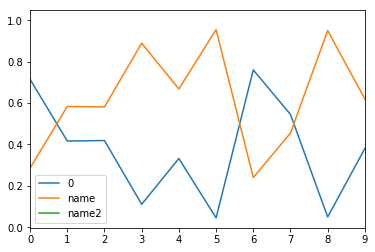

In [4]:
x = np.random.rand(10)

df = pd.DataFrame(x)
df['name'] = np.ones(x.shape) - x
df.loc[2, 'name2'] = 1
df.to_pickle('table')
nes_df = pd.read_pickle('table')
print(df.columns)
#df.column = ['zero','one','two']
df.plot()

In [ ]:
# Path settings
# we use a relative path here, you can also specify an absolute path for your system
out_path = "output20"
os.makedirs(out_path, exist_ok=True)

In [ ]:
# Time dimension parameters
t_0 = 0            # initial time
T = 1.0            # final time
num_steps = 10     # number of time steps
dt = (T-t_0) / num_steps # time step size


In [ ]:
# Create mesh
length = 5
thickness = 5
height = 5
nelements = 20

mesh = BoxMesh(Point(-length/2, -thickness/2, -height/2), Point(length/2, thickness/2, height/2), nelements, nelements, nelements)
mesh

In [ ]:
# Define a function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

In [ ]:
# Create class that defines subdomains for bondaries conditions (inherits from fenics.SubDomain)
class LowerSide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[2], -height/2, tol)
    
class UpperSide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[2], height/2, tol)

In [ ]:
# Mark facets and save the result in .pvd file
domains_facets  = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1)
domains_facets.set_all(0)

# Mark bottom facets
bottom = LowerSide()
bottom.mark(domains_facets, 1)

# Mark upper facets
up = UpperSide()
up.mark(domains_facets, 2)

# Save in .pvd file
boundaries_file = File(os.path.join(out_path, "boundaries.pvd"))
boundaries_file << domains_facets

In [ ]:
# Integration over subdomains
ds = Measure('ds', domain=mesh, subdomain_data=domains_facets)

# Constant 3D vector
f = Constant((0,0,1))
# Surface normals of the cube
n = FacetNormal(mesh)

print("Integral over entire surface:      ", assemble(inner(f,n)*ds) )
print("Integral over lower surface only:   ", assemble(inner(f,n)*ds(1)) )
print("Integral over upper surface only:   ", assemble(inner(f,n)*ds(2)) )

In [ ]:
# Boundary conditions
u_0 = Constant((0,0,0))          # No displacement
u_t = Expression(('0','0','1*t'), degree=1, t=0)          # Traction
u_c = Expression(('0','0','-1*t'), degree=1, t=0)         # Compression
u_s = Expression(('1*t','0','0'), degree=1, t=0)          # Shearing

u_1 = u_s                        # Define displacement on upper part (type of test)

# Change boundary condition into a time dependent expression
#u_D = Expression('u*t', u=u_1, t=t_0)
#u_D = Expression(('x[0]', 'x[1]', 'x[2]*t'), degree=1, t=t_0)

# Define initial value
u_n = interpolate(u_1, V)

# Define bc as u_0 in the vector space V on the subdomain domains_facets labeled by 1 (lower facets)
bcl = DirichletBC(V, u_0, domains_facets, 1)
bcu = DirichletBC(V, u_1, domains_facets, 2)
bcs = [bcl, bcu]

In [ ]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
#B  = Constant((0.0, -0.5, 0.0))  # Body force per unit volume
#T  = Constant((0, 0, 10))         # Traction force on the boundary

In [ ]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                  # Identity tensor
F = I + grad(u)                  # Deformation gradient
F = variable(F)                  # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation
C = F.T*F                        # Right Cauchy-Green tensor

In [ ]:
# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

In [ ]:
# Elasticity parameters
E, nu = 10.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

In [ ]:
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

In [ ]:
# Total potential energy
#Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds       # with body force B and traction force T
#Pi = psi*dx - dot(T, u)*ds(2)                   # without body force B
Pi = psi*dx                                      # without traction force

In [ ]:
# Compute first variation of Pi (directional derivative about u in the direction of v)
Fpi = derivative(Pi, u, v)

In [ ]:
# Compute Jacobian of Fpi
J = derivative(Fpi, u, du)

In [ ]:
# Create VTK file for the solution
fileU = File(os.path.join(out_path, "displacement.pvd"));
fileS = File(os.path.join(out_path, "stress.pvd"));
fileV = File(os.path.join(out_path, "stress_von_mises.pvd"));

In [ ]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

In [ ]:
# Define the solver
problem = NonlinearVariationalProblem(Fpi, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'cg'
prm['newton_solver']['preconditioner'] = 'icc'

#prm['newton_solver']['error_on_nonconvergence'] = True
#prm['newton_solver']['absolute_tolerance'] = 1E-9
#prm['newton_solver']['relative_tolerance'] = 1E-8
#prm['newton_solver']['maximum_iterations'] = 25
#prm['newton_solver']['relaxation_parameter'] = 1.0

#prm['newton_solver']['lu_solver']['reuse_factorization'] = False
#prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = False
#prm['newton_solver']['lu_solver']['symmetric'] = False

#prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = True
#prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
#prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-5
#prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
#prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
#if prm['newton_solver']['linear_solver'] == 'gmres':
#    prm['newton_solver']['preconditioner'] = 'ilu'

In [ ]:
# Time-stepping
t = t_0
Stime = []
for n in range(num_steps+1):

    # Update current time
    u_1.t = t

    # Compute solution
    tic = time.clock()
    #solve(Fpi == 0, u, bcs, J=J)
    #solve(Fpi == 0, u, bcs, J=J, form_compiler_parameters=ffc_options)       # solve using optimization options
    solver.solve()
    toc = time.clock()
    
    # Save solving time in an array
    Stime.append(toc-tic)

    # Save solution in VTK format
    fileU << (u, t);
    
    # compute max / min displacement
    W = FunctionSpace(mesh, 'P', 1)

    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, W)
    print('Min/Max displacement:',
          u_magnitude.vector().get_local().min(),
          u_magnitude.vector().get_local().max())

    # Computation of the stresses
    Z = TensorFunctionSpace(mesh, 'P', 1)
    print("Stress derivation and saving to file")
    S = diff(psi, F)            # compute stress by differentiation of psi!
    S_project = project(S, Z, solver_type='cg')
    S_project.rename("stress", "")
    fileS << (S_project, t);
    
    # Computation of van Mises Stress
    s = S - (1./3) * tr(S) * Identity(u.geometric_dimension())
    von_Mises = sqrt( 3./2 * inner(s, s) )
    von_Mises_project = project(von_Mises, W)
    von_Mises_project.rename("von_mises", "")
    fileV << (von_Mises_project, t);
    print("Maximum equivalent stress:", von_Mises_project.vector().get_local().max())

    # Update previous solution
    u_n.assign(u)
    
    # Update time
    t += dt

In [ ]:
# Save time to solve each iteration
print(Stime)
np.savetxt(os.path.join(out_path, "solving_time.txt"), Stime, fmt='%1.4e')   # use exponential notation

In [ ]:
## Panda package 